# **TextRank**

# Module 1: Tiền xử lý tổng quát

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# 1. Cài đặt thư viện cần thiết
!pip install underthesea rouge-score scikit-learn pandas networkx matplotlib seaborn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
from rouge_score import rouge_scorer

In [13]:
# 2. Hàm làm sạch văn bản
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [14]:
# 3. Hàm tách từ
def segment_text(text):
    try:
        return word_tokenize(text, format="text")
    except:
        return text

In [15]:
# 4. Chuẩn bị dữ liệu
df = pd.read_csv("/content/drive/MyDrive/NLP_PROJECT/data/csv_file/original_summary.csv")

print("Đang xử lý dữ liệu...")
df['clean_content'] = df['content'].apply(clean_text)
df['clean_summary'] = df['summary'].apply(clean_text)

# Tạo cột đã tách từ (Dành cho các model cần Word Segmentation)
df['segmented_content'] = df['clean_content'].apply(segment_text)
df['segmented_summary'] = df['clean_summary'].apply(segment_text)

print(f"Đã tải {len(df)} mẫu dữ liệu.")
df.head(2)

Đang xử lý dữ liệu...
Đã tải 100 mẫu dữ liệu.


,title,content,summary,clean_content,clean_summary,segmented_content,segmented_summary
0,Làng gốm Thanh Hà giành giải 'Điểm du lịch cộn...,"Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l...","Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l...","Sáng 27/9 , làng gốm_Thanh_Hà ( phường Thanh_H...","Làng gốm Thanh_Hà được vinh_danh là "" Điểm du_..."
1,"""Đọc bã"" cà phê đoán vận mệnh ở Thổ Nhĩ Kỳ","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t...","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t...","Ở Thổ_Nhĩ_Kỳ , cà_phê đi kèm một_chút định_mện...","Ở Thổ_Nhĩ_Kỳ , khi uống cạn cà_phê , người_dân..."


# Module 2: Mô hình chính

In [16]:
#  Cài đặt thư viện cần thiết
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from underthesea import sent_tokenize


import textwrap
import os
from difflib import SequenceMatcher

In [17]:
# Cài đặt Stopword và hàm dự đoán
STOPWORDS = set(['thì', 'là', 'mà', 'và', 'của', 'những', 'các', 'trong', 'khi', 'đã', 'đang', 'vẫn', 'sẽ', 'cũng', 'với', 'như', 'vì'])

def textrank_predict(text, top_k=3):
    sentences = sent_tokenize(text)
    if len(sentences) <= top_k:
        return text

    processed_sentences = []
    for sent in sentences:
        words = word_tokenize(sent, format="text").split()
        clean_words = [w.lower() for w in words if w.lower() not in STOPWORDS and w.isalnum()]
        processed_sentences.append(" ".join(clean_words))

    try:
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(processed_sentences)
        similarity_matrix = cosine_similarity(tfidf_matrix)
    except ValueError:
        return sentences[0]

    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph, max_iter=500)

    # Chọn Top-K câu có điểm cao nhất
    ranked_sentences = sorted(((scores[i], i) for i in range(len(sentences))), reverse=True)
    top_indices = [i for score, i in ranked_sentences[:top_k]]
    top_indices.sort()

    final_summary = " ".join([sentences[i] for i in top_indices])
    return final_summary

df['predicted_summary'] = df['clean_content'].apply(lambda x: textrank_predict(x, top_k=3))

In [18]:
# Tạo output
output_path = "/content/drive/MyDrive/NLP_PROJECT/Model/TextRank_results/Result_TextRank.csv"
output_filename = os.path.basename(output_path)
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    print(f"Thư mục '{output_dir}' chưa có -> Đang tạo mới...")
    os.makedirs(output_dir, exist_ok=True)

df[['clean_content', 'clean_summary', 'predicted_summary']].to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Đã lưu kết quả dự đoán vào file: {output_filename}")

print("\n=== KIỂM TRA NHANH KẾT QUẢ TEXTRANK ===")
sample = df.sample(1).iloc[0]

print("1. BÀI BÁO GỐC (Trích đoạn):")
print(textwrap.fill(sample['clean_content'][:300] + "...", width=80))

print("\n2. TÓM TẮT MẪU (Human):")
print(textwrap.fill(str(sample['clean_summary']), width=80))

print("\n3. TÓM TẮT TEXTRANK (Machine):")
print(textwrap.fill(str(sample['predicted_summary']), width=80))
print("="*80)

Đã lưu kết quả dự đoán vào file: Result_TextRank.csv

=== KIỂM TRA NHANH KẾT QUẢ TEXTRANK ===
1. BÀI BÁO GỐC (Trích đoạn):
Theo công bố hồi đầu tháng 9, nền tảng này đánh giá các khu phố cổ dựa trên bốn
tiêu chí: không gian đi bộ, tuổi đời, phí tham quan và mức độ phổ biến trên
Instagram. Hội An dẫn đầu khu vực châu Á nhờ kiến trúc thế kỷ 16 được bảo tồn
tốt, vé tham quan chỉ hai euro (khoảng 2,36 USD) và không gian thâ...

2. TÓM TẮT MẪU (Human):
Đầu tháng 9, nền tảng du lịch trực tuyến Tourlane của Pháp đã công bố bảng xếp
hạng các khu phố cổ ấn tượng nhất thế giới. Tin vui cho du lịch Việt Nam là Phố
cổ Hội An đã vượt qua nhiều điểm đến danh tiếng để đứng đầu khu vực châu Á. Nằm
cách Đà Nẵng 30 km, thương cảng sầm uất một thời (từng gọi là Faifo) chinh phục
các chuyên gia nhờ mức phí tham quan thấp (khoảng 2 euro), không gian thân thiện
với người đi bộ và quần thể kiến trúc thế kỷ 16 được bảo tồn gần như nguyên vẹn.
Với 1.360 di tích gồm nhà cổ, hội quán, chùa cầu mang đậm dấu ấn gi

# Module 3: Đánh giá & vẽ biểu đồ

In [19]:
#  Cài đặt thư viện cần thiết
from rouge_score import rouge_scorer
from underthesea import word_tokenize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [20]:
# Thiết lập các biến và tải dữ liệu kết quả từ file CSV hoặc sử dụng DataFrame hiện có
RESULT_FILE_PATH = "/content/drive/MyDrive/NLP_PROJECT/Model/TextRank_results/Result_TextRank.csv"
MODEL_NAME = "TextRank"
col_gen = "predicted_summary"
col_ref = "clean_summary"
col_src = "clean_content"

if not os.path.exists('/content/drive'): drive.mount('/content/drive')

if os.path.exists(RESULT_FILE_PATH):
    df = pd.read_csv(RESULT_FILE_PATH).dropna(subset=[col_gen, col_ref])
else:
    try:
        df = df.copy()
    except NameError:
        raise FileNotFoundError("Không tìm thấy dữ liệu (File CSV hoặc biến df).")

In [21]:
# Định nghĩa hàm đánh giá ROUGE cho tiếng Việt và tính toán các chỉ số ROUGE
def evaluate_rouge_vietnamese(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(preds, refs):
        pred = str(pred) if pd.notna(pred) else ""
        ref = str(ref) if pd.notna(ref) else ""

        pred_seg = word_tokenize(pred, format="text")
        ref_seg = word_tokenize(ref, format="text")

        score = scorer.score(ref_seg, pred_seg)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    return {k: np.mean(v) for k, v in scores.items()}

rouge_results = evaluate_rouge_vietnamese(df[col_gen], df[col_ref])
print(f"ROUGE Results for {MODEL_NAME}: {rouge_results}")

df_current = df.copy()
df_current['gen_len'] = df_current[col_gen].apply(lambda x: len(str(x).split()))
df_current['ref_len'] = df_current[col_ref].apply(lambda x: len(str(x).split()))
df_current['src_len'] = df_current[col_src].apply(lambda x: len(str(x).split()))
df_current['length_group'] = df_current['src_len'].apply(lambda x: "< 300" if x < 300 else ("300-600" if x <= 600 else "> 600"))

ROUGE Results for TextRank: {'rouge1': np.float64(0.5122475376211794), 'rouge2': np.float64(0.28947507535391137), 'rougeL': np.float64(0.3007593844985763)}


In [22]:
#  Cài đặt thư viện cần thiết
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/tmp/ipython-input-1615617113.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics, y=values, palette="viridis")


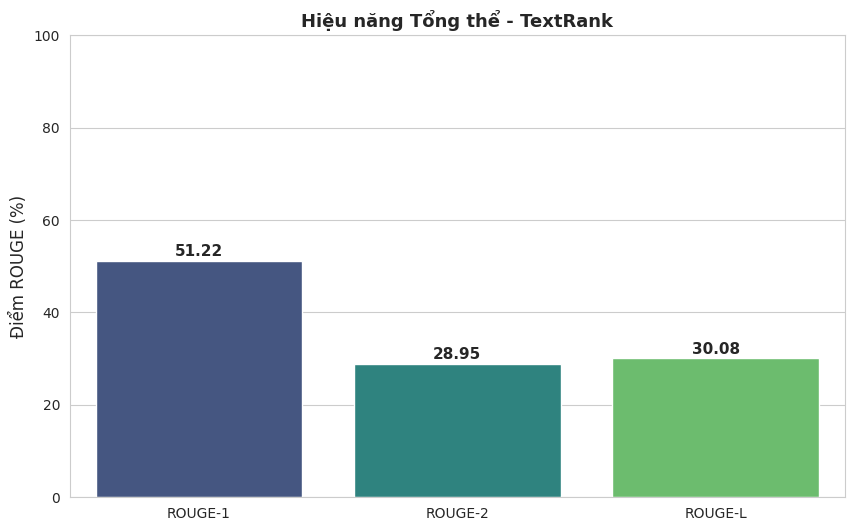

In [23]:
# BIỂU ĐỒ 1: HIỆU NĂNG TỔNG THỂ

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
values = [
    rouge_results['rouge1'] * 100,
    rouge_results['rouge2'] * 100,
    rouge_results['rougeL'] * 100
]

ax = sns.barplot(x=metrics, y=values, palette="viridis")

plt.title(f"Hiệu năng Tổng thể - {MODEL_NAME}", fontsize=13, weight='bold')
plt.ylabel("Điểm ROUGE (%)", fontsize=12)
plt.ylim(0, 100)

for i, v in enumerate(values):
    ax.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=11, fontweight='bold')

plt.show()

/tmp/ipython-input-346215460.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=g_scores, palette="magma")


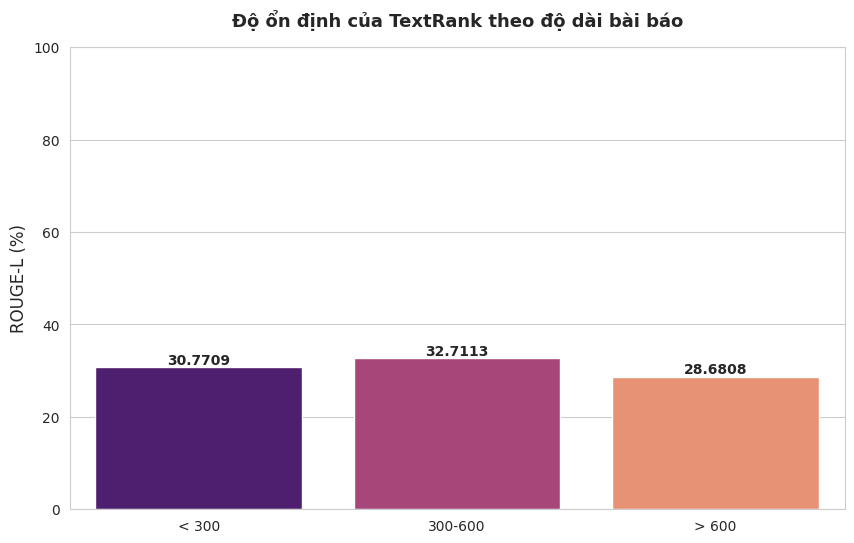

In [24]:
# BIỂU ĐỒ 2: ROUGE THEO ĐỘ DÀI
plt.figure(figsize=(10, 6))
groups = ["< 300", "300-600", "> 600"]
g_scores = []

for g in groups:
    sub = df_current[df_current["length_group"] == g]
    score = evaluate_rouge_vietnamese(sub[col_gen], sub[col_ref])['rougeL'] if len(sub) > 0 else 0
    g_scores.append(score * 100)

sns.barplot(x=groups, y=g_scores, palette="magma")
plt.title(f"Độ ổn định của {MODEL_NAME} theo độ dài bài báo", fontsize=13, weight='bold', pad=15)
plt.ylabel("ROUGE-L (%)", fontsize=12)
plt.xlabel("")
plt.ylim(0, 100)
for i, v in enumerate(g_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
plt.show()


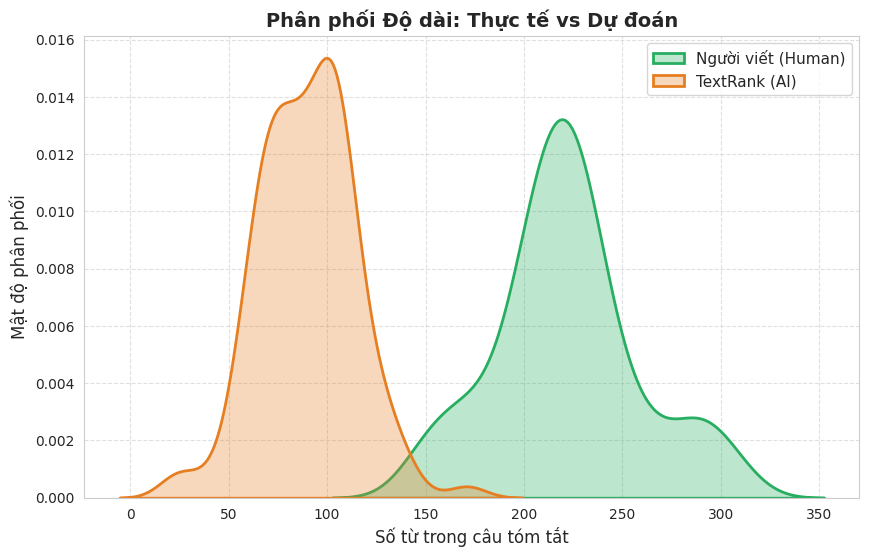

In [25]:
# ==============================================================================
# BIỂU ĐỒ 3: SO SÁNH PHÂN PHỐI ĐỘ DÀI
# ==============================================================================
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_current, x="ref_len", fill=True,
    label="Người viết (Human)", color="#27ae60", alpha=0.3, linewidth=2
)

sns.kdeplot(
    data=df_current, x="gen_len", fill=True,
    label=f"{MODEL_NAME} (AI)", color="#e67e22", alpha=0.3, linewidth=2
)

plt.title("Phân phối Độ dài: Thực tế vs Dự đoán", fontsize=14, weight='bold')
plt.xlabel("Số từ trong câu tóm tắt", fontsize=12)
plt.ylabel("Mật độ phân phối", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

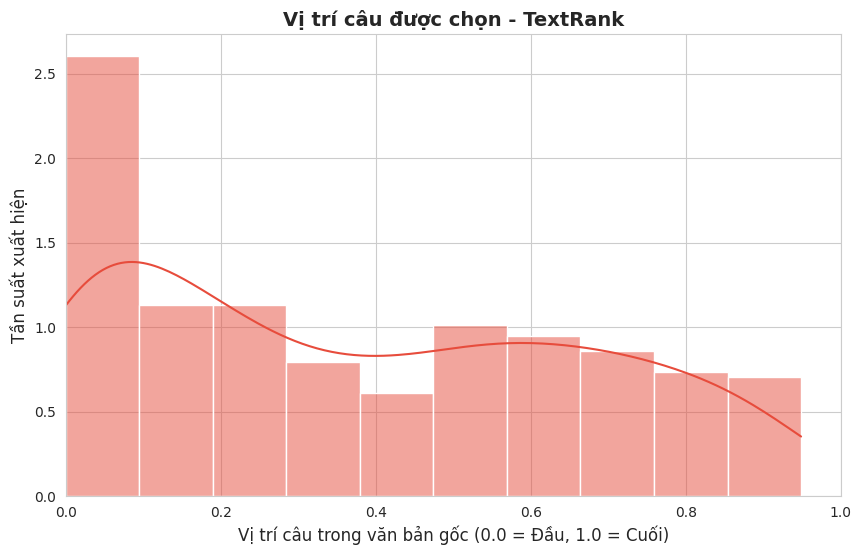

In [26]:
# ==============================================================================
# BIỂU ĐỒ 4: THIÊN KIẾN VỊ TRÍ (LEAD BIAS)
# ==============================================================================
from difflib import SequenceMatcher

def find_best_match_position(generated_text, original_text):
    gen_sents = str(generated_text).split('.')
    org_sents = str(original_text).split('.')
    if len(org_sents) == 0: return []

    positions = []
    for g_sent in gen_sents:
        if len(g_sent) < 10: continue
        best_ratio = 0
        best_idx = 0
        for i, o_sent in enumerate(org_sents):
            ratio = SequenceMatcher(None, g_sent, o_sent).ratio()
            if ratio > best_ratio:
                best_ratio = ratio
                best_idx = i
        if best_ratio > 0.5:
            positions.append(best_idx / len(org_sents))
    return positions

all_positions = []
for idx, row in df_current.iterrows():
    pos = find_best_match_position(row[col_gen], row[col_src])
    all_positions.extend(pos)

plt.figure(figsize=(10, 6))
sns.histplot(all_positions, bins=10, kde=True, color="#e74c3c", stat="density")

plt.title(f"Vị trí câu được chọn - {MODEL_NAME}", fontsize=14, weight='bold')
plt.xlabel("Vị trí câu trong văn bản gốc (0.0 = Đầu, 1.0 = Cuối)", fontsize=12)
plt.ylabel("Tần suất xuất hiện", fontsize=12)
plt.xlim(0, 1)

plt.show()